In [1]:
from fastai.vision.all import *
from fastai.learner import *
from fastai.data.all import *
from fastai.callback.tracker import SaveModelCallback
import pandas as pd
import matplotlib.pyplot as plt
from pathlib2 import Path
import numpy as np
import random
from torch.nn import MSELoss
from IPython.lib.display import Audio
from python_speech_features.base import mfcc
import librosa

In [2]:
df_train = pd.read_csv('data/wikitext-103/train.csv', header=None)

In [3]:
df_train.shape

(29539, 1)

In [4]:
texts = df_train[0].tolist()
texts = texts[:2000]

In [5]:
import logging
from six import iteritems
from web.datasets.similarity import fetch_MEN, fetch_WS353, fetch_SimLex999
from web.embeddings import fetch_GloVe
from web.evaluate import evaluate_similarity
from web.embedding import Embedding, Vocabulary
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.datasets.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [6]:
speech2vec = KeyedVectors.load_word2vec_format('../speech2vec-pretrained-vectors/speech2vec/50.vec', binary=False) 

vocab = set(speech2vec.vocab.keys())
len(vocab)

37622

In [7]:
# mkdir -p data/audio

In [8]:
# from time import sleep

In [9]:
# %%time

# from google.cloud import texttospeech

# client = texttospeech.TextToSpeechClient()

# for i, word in enumerate(vocab):
#     if i % 300 == 0: sleep(60)

#     synthesis_input = texttospeech.SynthesisInput(text=word)

#     voice = texttospeech.VoiceSelectionParams(
#         language_code="en-US", ssml_gender=texttospeech.SsmlVoiceGender.NEUTRAL
#     )

#     audio_config = texttospeech.AudioConfig(
#         audio_encoding=texttospeech.AudioEncoding.MP3
#     )

#     response = client.synthesize_speech(
#         input=synthesis_input, voice=voice, audio_config=audio_config
#     )

#     # The response's audio_content is binary.
#     with open(f"data/audio/{word}.mp3", "wb") as out:
#         out.write(response.audio_content)

In [10]:
# %%time

# import warnings
# warnings.filterwarnings('ignore')

# word2ary = {}

# for word in vocab:
#     ary, _ = librosa.load(f'data/audio/{word}.mp3', sr=16000)
#     word2ary[word] = ary
    
# pd.to_pickle(word2ary, 'word2ary.pkl')

In [11]:
word2ary = pd.read_pickle('word2ary.pkl')

In [12]:
%%time

word2features = {}
for k, v in word2ary.items():
    word2features[k] = mfcc(v)

CPU times: user 7min 14s, sys: 6.64 s, total: 7min 20s
Wall time: 1min 13s


In [13]:
from joblib import Parallel, delayed
from functools import partial
from spacy.util import minibatch
import spacy
from spacy.attrs import ORTH, LEMMA

nlp = spacy.load("en_core_web_sm")

nlp.tokenizer.add_special_case('<unk>', [{ORTH: "<unk>"}])
nlp.tokenizer.add_special_case('<eos>', [{ORTH: "<eos>"}])

batch_size= 200
partitions = minibatch(texts, size=batch_size)

executor = Parallel(n_jobs=10, backend="multiprocessing", prefer="threads")

def transform_texts(nlp, vocab, text):
    docs = nlp.tokenizer.pipe(texts)
    word_pairs = []
    
    for doc in docs:
        words = [token.text.lower() for token in doc if token.is_alpha]
        words = [w if w in vocab else '<UNK>' for w in words]
        
        for i, word in enumerate(words):
            if word == '<UNK>': continue
            for offset in [-2, -1, 1, 2]:
                if i + offset < 0 or i + offset >= len(words): continue
                target_word = words[i+offset]
                if target_word == '<UNK>': continue
                word_pairs.append([word, target_word])
                 
    return word_pairs

In [14]:
%%time

do = delayed(partial(transform_texts, nlp, vocab))
tasks = (do(batch) for batch in partitions)
word_pairs_hierarchical = executor(tasks)

CPU times: user 1min 56s, sys: 17.7 s, total: 2min 13s
Wall time: 4min 1s


In [15]:
word_pairs = []

for pairs in word_pairs_hierarchical: word_pairs += pairs

In [16]:
word_pairs[:10]

[['is', 'a'],
 ['a', 'is'],
 ['a', 'genus'],
 ['genus', 'a'],
 ['genus', 'in'],
 ['genus', 'the'],
 ['in', 'genus'],
 ['in', 'the'],
 ['in', 'family'],
 ['the', 'genus']]

In [17]:
len(word_pairs)

184410700

In [18]:
len(word_pairs)

184410700

In [16]:
vocab = list(vocab)
word2index = {w: i for i, w in enumerate(vocab)}

In [17]:
def prepare_features(word, pad_to=70, pad_left=False):
    ary = word2features[word][:pad_to]
    example = np.zeros((pad_to, 13))
    if pad_left:
        example[-ary.shape[0]:, :] = ary
    else: example[:ary.shape[0], :] = ary
    return example.astype(np.float32)

In [18]:
dataset_mean = -2
dataset_std = 10

def normalize_data(ary):
    return (ary - dataset_mean) / dataset_std

In [19]:
fn2features = {}
for word in vocab:
    fn2features[word] = normalize_data(prepare_features(word))

In [20]:
class Dataset():
    def __init__(self, pairs, length=10_000_000):
        self.pairs = pairs
        self.len = length
    def __len__(self):
        return self.len
    def __getitem__(self, idx):
        source_word, target_word = self.pairs[np.random.randint(len(self.pairs))]
        return fn2features[source_word], word2index[target_word]

In [21]:
# 14 mln -> 180 mln

In [22]:
len(word_pairs)

184410700

In [23]:
train_ds = Dataset(word_pairs)
valid_ds = Dataset(word_pairs, 1_000_000)

In [24]:
len(train_ds), len(valid_ds)

(10000000, 1000000)

In [25]:
BS = 2048
NUM_WORKERS = 8

train_dl = DataLoader(train_ds, BS, NUM_WORKERS, shuffle=True)
valid_dl = DataLoader(valid_ds, BS, NUM_WORKERS)

dls = DataLoaders(train_dl, valid_dl)

In [26]:
class Model(Module):
    def __init__(self, hidden_size=25):
        self.return_embeddings = False
        self.hidden_size = hidden_size
        
        self.encoder= nn.LSTM(
            input_size=13,
            hidden_size=hidden_size,
            num_layers=3,
            batch_first=True,
            dropout=0,
            bidirectional=True
        )
        
        self.linear = nn.Linear(2*hidden_size, len(vocab))
            
    def forward(self, source_features):
        _, (embeddings, _) = self.encoder(source_features)        
        embeddings = torch.cat((embeddings[-1], embeddings[-2]), 1)
        
        if self.return_embeddings: return embeddings

        return self.linear(embeddings)

In [27]:
learn = Learner(
    dls.cuda(),
    Model().cuda(),
    loss_func=CrossEntropyLossFlat(),
    opt_func=Adam,
    metrics=[accuracy]
)

In [ ]:
NUM_EPOCHS = 200
learn.fit(NUM_EPOCHS, lr=1e-3, cbs=SaveModelCallback(fname='rnn_encoder', every_epoch=True))

epoch,train_loss,valid_loss,accuracy,time
0,6.937828,6.943904,0.093364,07:57
1,6.894700,6.889863,0.094532,08:04
2,6.850228,6.861458,0.095167,06:44
3,6.839160,6.839796,0.095905,06:21
4,6.817207,6.825046,0.096110,07:06
5,6.808103,6.811345,0.096223,06:26
6,6.796218,6.804134,0.096441,06:45
7,6.792039,6.788680,0.097343,06:44
8,6.782446,6.785172,0.096652,06:39
9,6.780403,6.775949,0.097271,07:29


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

## Evalute embeddings

In [28]:
from utils import Embeddings

In [29]:
class DatasetPred():
    def __len__(self):
        return len(vocab)
    def __getitem__(self, idx):
        _, target_word = word_pairs[np.random.randint(len(word_pairs))]
        source_word = vocab[idx]
        return fn2features[source_word], word2index[target_word]

In [30]:
pred_dl = DataLoader(DatasetPred(), BS, NUM_WORKERS)

In [31]:
learn.load('rnn_encoder_199')

In [32]:
%%time

learn.model.return_embeddings = True
learn.model.eval()

all_embeddings = []

with torch.no_grad():    
    for batch in pred_dl:
        embeddings = learn.model(batch[0].cuda())
        all_embeddings.append(embeddings.detach().cpu().squeeze(0))

CPU times: user 224 ms, sys: 3.68 s, total: 3.9 s
Wall time: 4.87 s


In [33]:
embeddings = torch.cat(all_embeddings)

In [34]:
e = Embeddings(
    embeddings,
    vocab
)

In [ ]:
for w in ['fast', 'lost', 'small', 'true', 'crazy', 'slow']:
    print(f'{w}: {e.nn_words_to(e[w])}')

## Evaluating embeddings using [word-embeddings-benchmarks](https://github.com/kudkudak/word-embeddings-benchmarks)

In [36]:
import logging
from six import iteritems
from web.datasets.similarity import fetch_MEN, fetch_WS353, fetch_SimLex999
from web.embeddings import fetch_GloVe
from web.evaluate import evaluate_similarity
from web.embedding import Embedding, Vocabulary
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [37]:
tasks = {
    "MEN": fetch_MEN(),
    "WS353": fetch_WS353(),
    "SIMLEX999": fetch_SimLex999()
}

In [38]:
our_embeddings = Embedding(
    Vocabulary(vocab),
    embeddings
)

speech2vec = KeyedVectors.load_word2vec_format('../speech2vec-pretrained-vectors/word2vec/50.vec', binary=False) 
speech2vec_embeddings = Embedding(Vocabulary(list(speech2vec.vocab.keys())), speech2vec.vectors)

In [39]:
for name, data in iteritems(tasks):
    print("Spearman correlation of scores on {} {}".format(name, evaluate_similarity(our_embeddings, data.X, data.y)))

Missing 392 words. Will replace them with mean vector
/opt/conda/lib/python3.7/site-packages/web-0.0.1-py3.7.egg/web/evaluate.py:336: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  A = np.vstack(w.get(word, mean_vector) for word in X[:, 0])
/opt/conda/lib/python3.7/site-packages/web-0.0.1-py3.7.egg/web/evaluate.py:337: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  B = np.vstack(w.get(word, mean_vector) for word in X[:, 1])
Missing 61 words. Will replace them with mean vector
Missing 24 words. Will replace them with mean vector


Spearman correlation of scores on MEN 0.13716165687788728
Spearman correlation of scores on WS353 0.11457108430299541
Spearman correlation of scores on SIMLEX999 0.05293036082814397


In [40]:
for name, data in iteritems(tasks):
    print("Spearman correlation of scores on {} {}".format(name, evaluate_similarity(speech2vec_embeddings, data.X, data.y)))

Missing 392 words. Will replace them with mean vector
Missing 61 words. Will replace them with mean vector
Missing 24 words. Will replace them with mean vector


Spearman correlation of scores on MEN 0.6056592803599269
Spearman correlation of scores on WS353 0.43349390636024643
Spearman correlation of scores on SIMLEX999 0.25938770901422736


## Loss decrease and improvements on semantic tasks as training progresses

In [46]:
%%capture

val_losses, accuracies, task_perf = [], [], []
for i in range(NUM_EPOCHS):
    learn.load(f'rnn_encoder_{i}')
#     loss, accuracy = learn.validate()
#     val_losses.append(loss)
#     accuracies.append(accuracy)
    
    learn.model.return_embeddings = True
    learn.model.eval()

    all_embeddings = []

    with torch.no_grad():    
        for batch in pred_dl:
            embeddings = learn.model(batch[0].cuda())
            all_embeddings.append(embeddings.detach().cpu().squeeze(0))

    embeddings = torch.cat(all_embeddings)
    our_embeddings = Embedding(
        Vocabulary([w.lower() for w in vocab]),
        embeddings
    )

    task_perf.append([evaluate_similarity(our_embeddings, data.X, data.y) for name, data in iteritems(tasks)])

In [47]:
men, ws353, simlex999 = list(zip(*task_perf))

In [48]:
import matplotlib.pyplot as plt

No handles with labels found to put in legend.


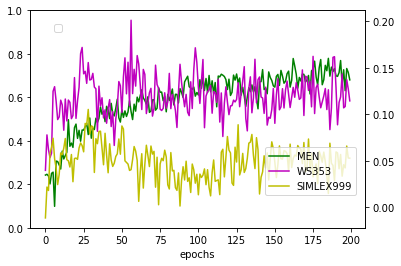

In [49]:
fig, ax1 = plt.subplots()

# ax1.plot(val_losses, label='val loss')

ax2 = ax1.twinx()
ax2.plot(men, label='MEN', c='g')
ax2.plot(ws353, label='WS353', c='m')
ax2.plot(simlex999, label='SIMLEX999', c='y')

ax1.legend(loc=[0.07, 0.9])
ax2.legend(loc=[0.7, 0.15])

ax1.set_xlabel('epochs');